In [324]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import kurtosis, skew
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder

%matplotlib inline


In [325]:
def quantile_75(x):
    ''' get the 75th percentile of x '''

    return np.quantile(x, 0.75)

In [326]:
def get_skeness_kurtosis(column):
    '''Calculate the skeness and kurtosis of a column '''

    # Skew     : > 1 or < -1 requires attention
    # Kurtosis : > 3  heavy tail

    # In box plots, a skewness is indicated when the median is closer to one side of the box and the whiskers are of unequal lengths.

    skew_value = skew(target_column, bias=False)
    kurt_value = kurtosis(target_column)

    return skew_value, kurt_value

In [327]:
def normalize_log_transform_column(log_transformed_column, original_column):
    '''Convert a column back from a log action to a value can render on the grid and understand '''

    return (log_transformed_column - np.min(log_transformed_column)) / (np.max(log_transformed_column) - np.min(log_transformed_column)) * (np.max(original_column) - np.min(original_column)) + np.min(original_column)

In [328]:
def iqr_technique(group):
    '''
    Outlier function for removing outliers
    :param column:
    :return:
    '''

    Q1 = np.percentile(group, 25)
    Q3 = np.percentile(group, 75)

    IQR = Q3 - Q1

    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)    # inter quantile range

    return np.quantile(np.arange(lower_range , upper_range, 100).tolist(), [0, 0.25, 0.5, 0.75, 1])

In [329]:
def iqr_technique_percentage(data, column):
    ''' Calculate the outlier % for the column '''

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)

    outliers = data[(data[column] < lower_range) | (data[column] > upper_range)]

    return (len(outliers)/len(data))*100

In [330]:
def predict_missing_values(df_transformed, colum_name):
    '''Predict the missing values for the column using RandomForestClassifier + OneHotEncoder'''

    missing = df_transformed[df_transformed[colum_name].isnull()]
    not_missing = df_transformed[df_transformed[colum_name].notnull()]

    encoder = OneHotEncoder(handle_unknown='ignore')
    encoded_features = encoder.fit_transform(not_missing[['age', 'balance', 'education', 'marital']])

    # Train a model to predict the missing values
    X_train, X_test, y_train, y_test = train_test_split(encoded_features, not_missing[colum_name], test_size=0.2, random_state=42)
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # Predict missing values
    encoded_missing_features = encoder.transform(missing[['age', 'balance', 'education', 'marital']])

    return model.predict(encoded_missing_features)

In [331]:
df = pd.read_csv('./bank.csv')
# average yearly balance	- balance
# housing / loan - type of loans
#
# default - has credit in default
#
# day / month - last contact day / month
# campaign - number of times user contacted during this campaign
#
# pdays (number of days passed after last campaign contact - if -1 previously not contacted)
#
# previous - number of times contacted during previous campaign
# poutcome - previous marketing campaign outcome
#
# result (subscribed)  -  if duration is zerp == no

In [332]:
# show me only the columns with missing values and the percentage
# if the % of the missing values is height we may drop the column
# missing values not numeric all enum types

missing_values_count = df.isnull().sum()
missing_percentage = (missing_values_count / len(df)) * 100

missing_data_summary = pd.DataFrame({
    'Missing Count': missing_values_count,
    'Missing % Total': missing_percentage
})

missing_data_summary = missing_data_summary[missing_data_summary['Missing Count'] > 0]

print(missing_data_summary)

           Missing Count  Missing % Total
age                   12             0.60
job                   10             0.50
education            104             5.20
contact              191             9.55
poutcome             454            22.70


In [333]:
# the iqr technique can be only used on numeric columns

numeric_df_column_names = df.select_dtypes(include=['number']).columns.tolist()

for index, column_name in enumerate(numeric_df_column_names, start=1):

    target_column = df[column_name]

    print(f" outliers {column_name} - {iqr_technique_percentage(df, column_name)} % out of total")

 outliers age - 1.2 % out of total
 outliers balance - 7.9 % out of total
 outliers day - 0.0 % out of total
 outliers duration - 4.6 % out of total
 outliers campaign - 10.6 % out of total
 outliers pdays - 1.6500000000000001 % out of total
 outliers previous - 8.450000000000001 % out of total


In [334]:
# replace yes + no with boolean to make it easy to get stats if the value is a boolean
# had to add the change as I wanted some stats and because the string where yes / no it was making my life hard (Panda likes booleans)

convert_yes_no_boolean = lambda x: True if x == 'yes' else False

df['housing'] = df['housing'].apply(convert_yes_no_boolean)
df['loan'] = df['loan'].apply(convert_yes_no_boolean)
df['subscribed'] = df['subscribed'].apply(convert_yes_no_boolean)
df['default'] = df['default'].apply(convert_yes_no_boolean)

In [335]:
# drop duplicates
# we may not have it - but get in to the habit of removing junk before doing any work
df = df.drop_duplicates()

# drop duration column - we don't know the data beforehand so for this task no need to be looking at it
if 'duration' in df.columns:
    df = df.drop(columns=['duration'])

In [336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         1988 non-null   float64
 1   job         1990 non-null   object 
 2   marital     2000 non-null   object 
 3   education   1896 non-null   object 
 4   default     2000 non-null   bool   
 5   balance     2000 non-null   int64  
 6   housing     2000 non-null   bool   
 7   loan        2000 non-null   bool   
 8   contact     1809 non-null   object 
 9   day         2000 non-null   int64  
 10  month       2000 non-null   object 
 11  campaign    2000 non-null   int64  
 12  pdays       2000 non-null   int64  
 13  previous    2000 non-null   int64  
 14  poutcome    1546 non-null   object 
 15  subscribed  2000 non-null   bool   
dtypes: bool(4), float64(1), int64(5), object(6)
memory usage: 195.4+ KB


In [337]:
df.describe()

,age,balance,day,campaign,pdays,previous
count,1988.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.753018,1413.663500,13.851500,1.909500,167.896000,2.561500
std,12.724358,3131.224213,9.712189,1.378862,131.754126,3.400735
min,18.000000,-980.000000,1.000000,1.000000,-1.000000,0.000000
25%,32.000000,201.500000,5.000000,1.000000,75.750000,1.000000
50%,38.000000,551.000000,12.000000,1.000000,182.000000,2.000000
75%,50.000000,1644.500000,23.000000,2.000000,251.000000,3.000000
max,93.000000,81204.000000,31.000000,11.000000,854.000000,55.000000


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,subscribed
0,32.0,technician,single,tertiary,False,392,True,False,cellular,1,apr,2,131,2,failure,False
1,39.0,technician,divorced,secondary,False,688,True,True,cellular,1,apr,2,133,1,failure,False
2,59.0,retired,married,secondary,False,1035,True,True,cellular,1,apr,2,239,1,failure,False
3,47.0,blue-collar,married,secondary,False,398,True,True,cellular,1,apr,1,238,2,failure,False
4,54.0,retired,married,secondary,False,1004,True,False,cellular,1,apr,1,307,1,failure,False
5,46.0,self-employed,divorced,tertiary,False,926,True,False,cellular,1,apr,1,133,3,failure,False
6,34.0,blue-collar,married,secondary,False,1924,True,True,cellular,1,apr,2,253,1,failure,False
7,45.0,services,divorced,secondary,False,396,True,True,cellular,1,apr,4,329,4,failure,False
8,58.0,management,divorced,tertiary,False,315,True,False,cellular,1,apr,2,135,2,failure,False
9,49.0,management,divorced,tertiary,False,20727,False,False,cellular,1,apr,3,132,2,failure,False


In [339]:
df.tail(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,subscribed
1995,20.0,student,single,NaN,False,2785,False,False,cellular,16,sep,2,-1,0,NaN,True
1996,28.0,admin.,single,secondary,False,127,False,False,cellular,16,sep,2,-1,0,NaN,True
1997,81.0,retired,married,primary,False,1154,False,False,telephone,17,sep,1,-1,0,NaN,True
1998,46.0,services,married,primary,False,4343,True,False,NaN,20,sep,1,-1,0,NaN,True
1999,40.0,entrepreneur,married,secondary,False,6403,False,False,cellular,22,sep,2,-1,0,NaN,True


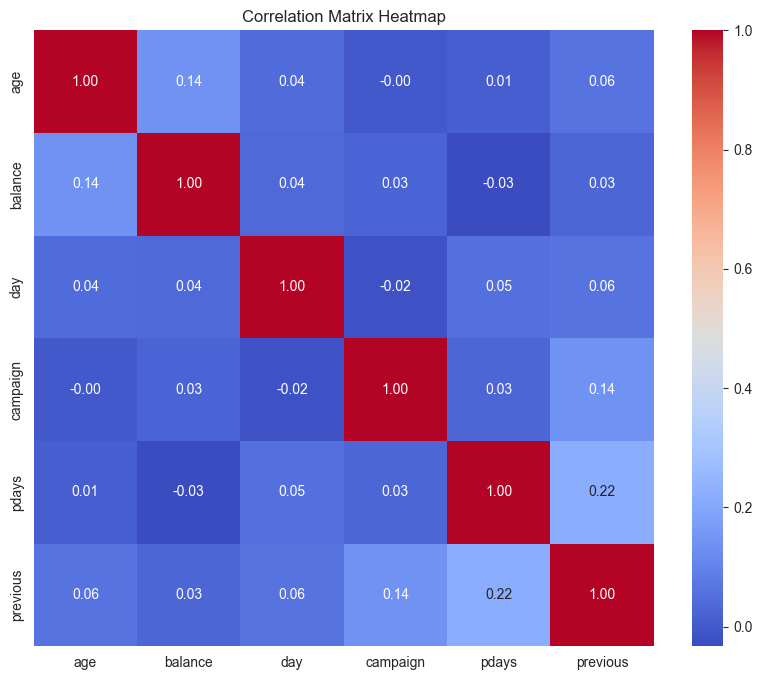

In [340]:
# show the heatmap of all the features

# Select only the numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

C:\Users\jorgeblx\AppData\Local\Temp\ipykernel_32332\3273093097.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\jorgeblx\AppData\Local\Temp\ipykernel_32332\3273093097.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45)


<Axes: title={'center': 'Customer Occupation Sorted'}>

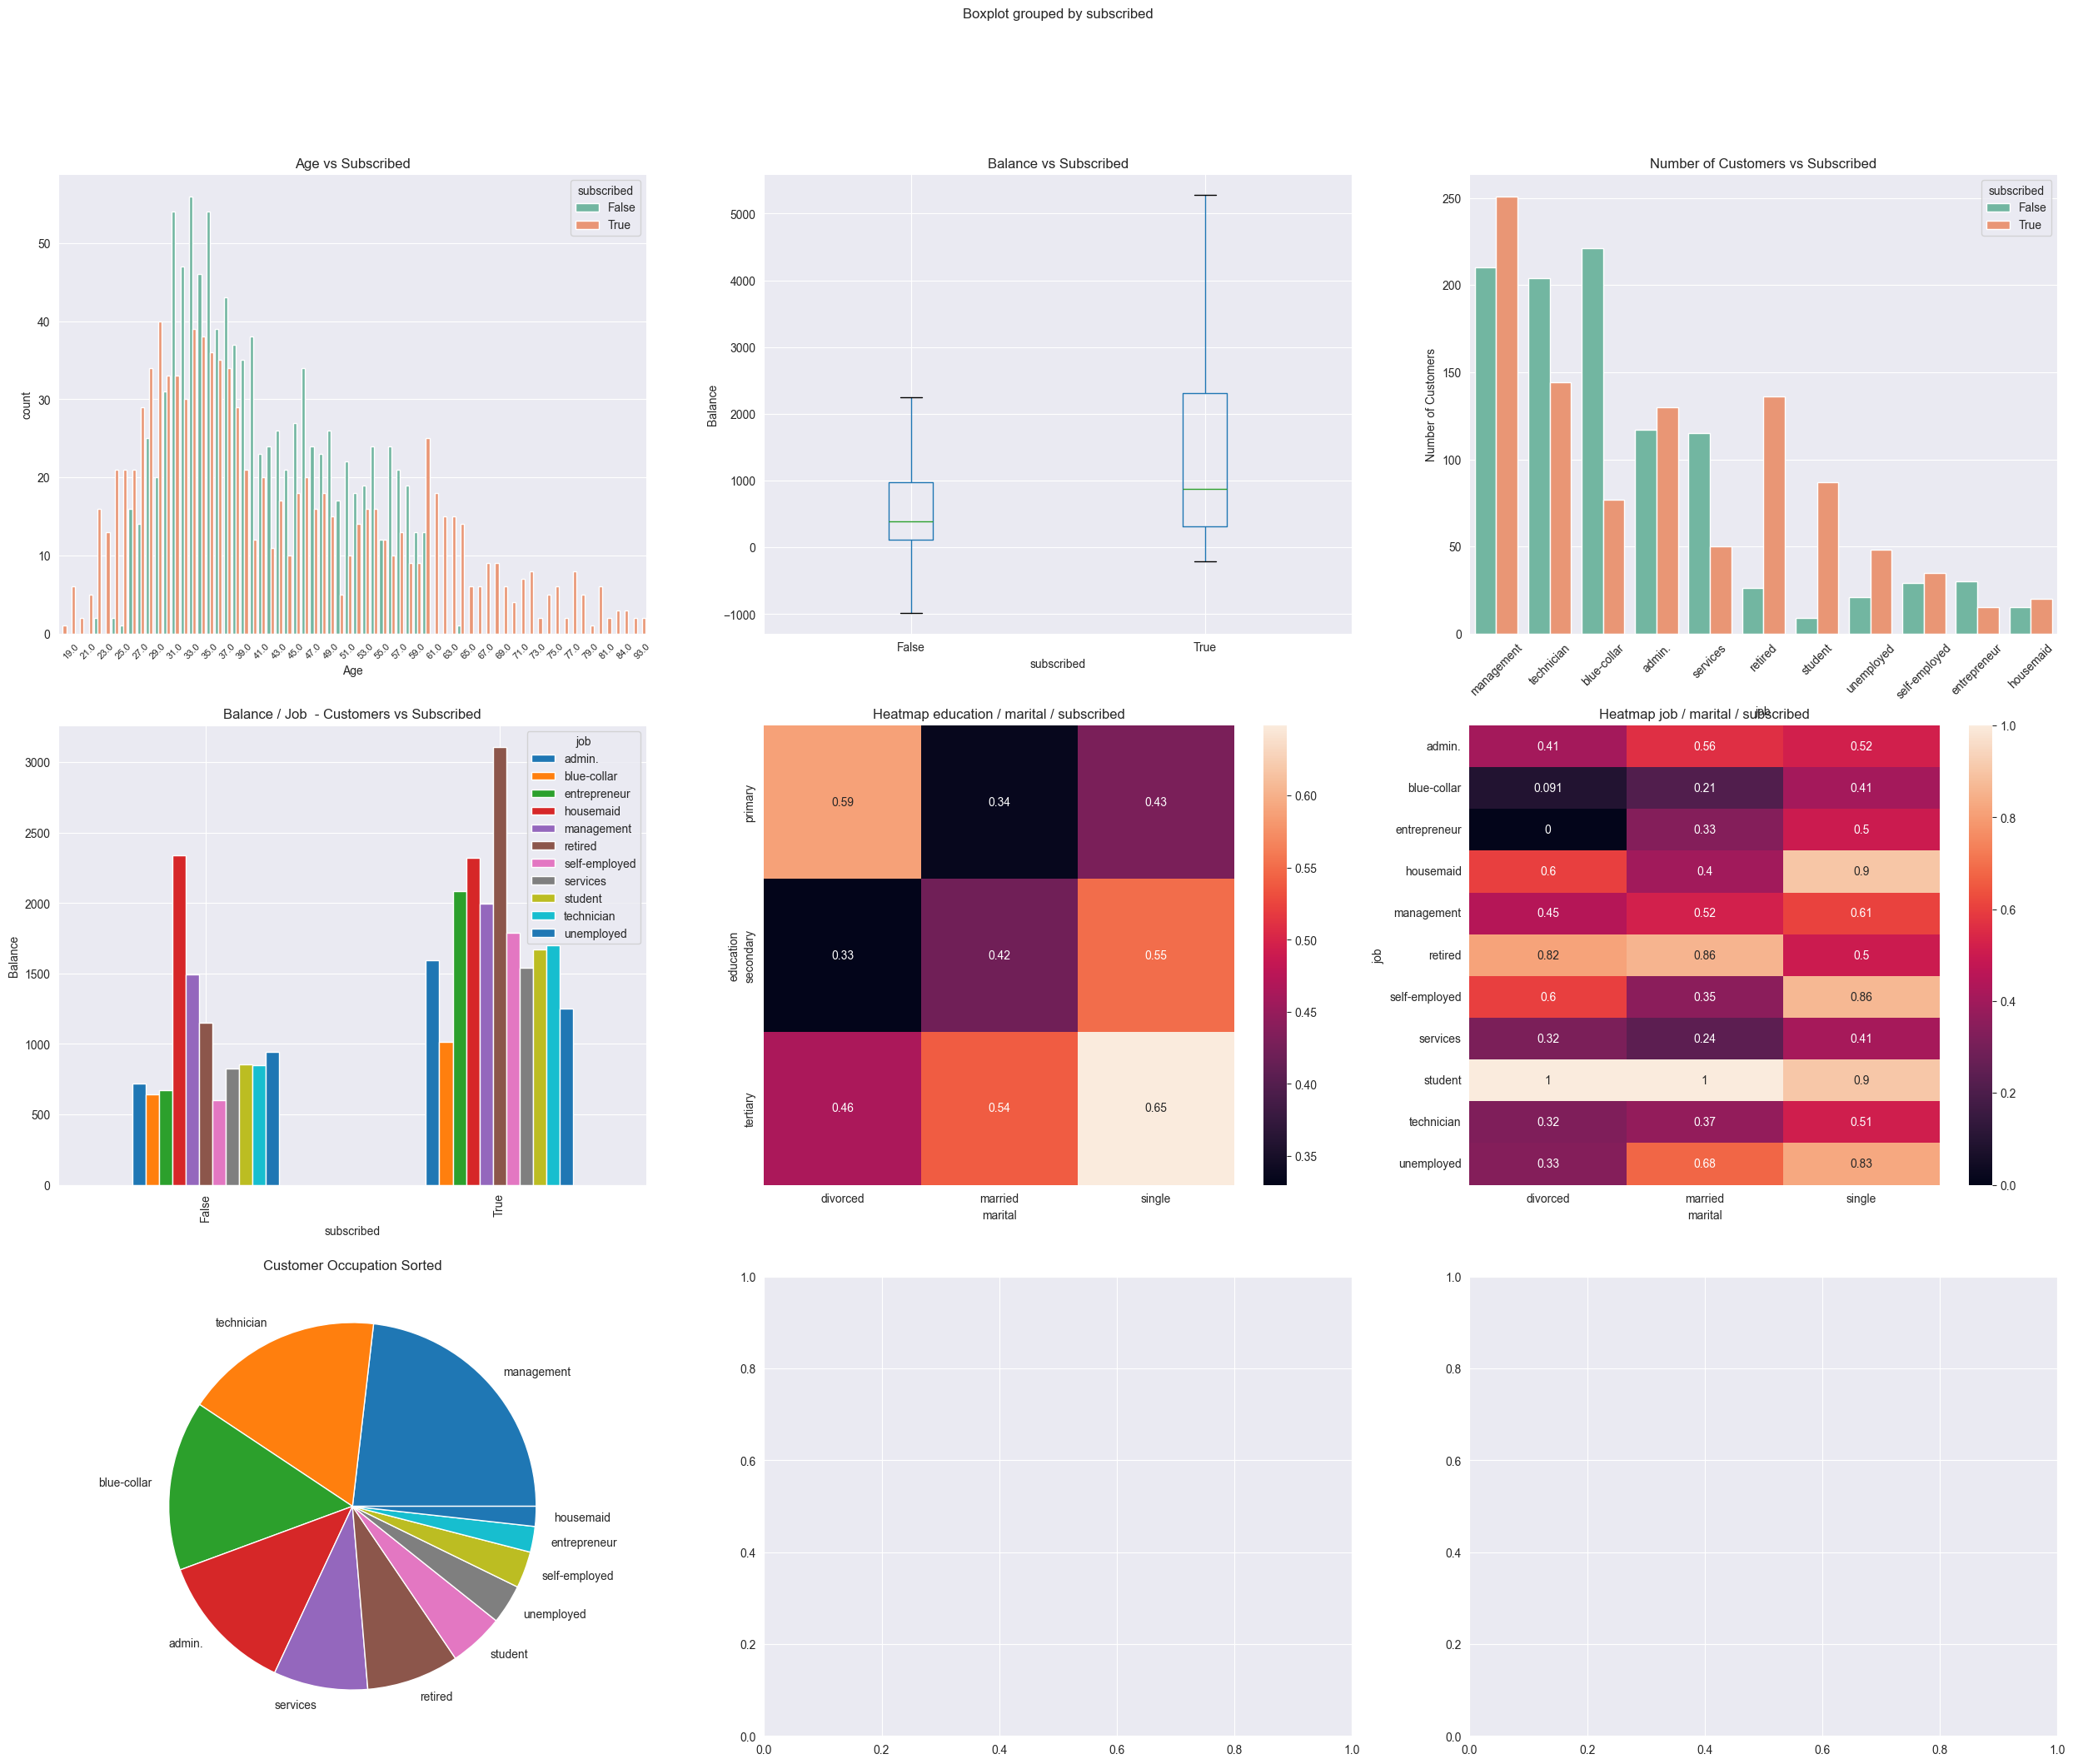

In [341]:
# basic stats - went for the simple approach
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 25))

# this is the age vs subscribed
axes[0, 0].set_title('Age vs Subscribed')
axes[0, 0].set_xlabel('Age')
plot = sns.countplot(x='age', hue='subscribed', data=df, palette="Set2", ax=axes[0, 0])
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, fontsize=8)

# hide every second x label
for index, label in enumerate(plot.get_xticklabels()):
    if index % 2 == 0:
        label.set_visible(False)

# balance vs subscribed
# this was a key plot for me as it told me, the subscription is based on the balance period :)
df.boxplot(column='balance', by='subscribed', showfliers=False, ax=axes[0, 1])
axes[0, 1].set_ylabel('Balance')
axes[0, 1].set_title('Balance vs Subscribed')

# this is the number of customers per job title vs subscribed
# I wanted to see if there was a predominant job title that was very active
# managment are the biggest group , but they are not the key players based on their balance
axes[0, 2].set_ylabel('Number of Customers')
axes[0, 2].set_title('Number of Customers vs Subscribed')
plot = sns.countplot(x='job', hue='subscribed', data=df,  ax=axes[0, 2], palette="Set2", order=df['job'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

# this is the bar chat balance vs job vs subscribed
# i wanted to see the jobs / balances for each subscription
grouped = df.groupby(['subscribed', 'job'])['balance'].mean().sort_values(ascending=False).unstack()
grouped.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_ylabel('Balance')
axes[1, 0].set_title('Balance / Job  - Customers vs Subscribed')

# this is the first heatmap
education_marital_subscribed = pd.pivot_table(data=df,index='education',columns='marital',values='subscribed')
sns.heatmap(education_marital_subscribed, annot=True, ax=axes[1, 1])
axes[1, 1].set_title('Heatmap education / marital / subscribed')

# this is the second heatmap
job_marital_subscribed = pd.pivot_table(data=df,index='job',columns='marital',values='subscribed')
sns.heatmap(job_marital_subscribed, annot=True, ax=axes[1, 2])
axes[1, 2].set_title('Heatmap job / marital / subscribed')

# breakdown of the titles
#  this is the pie chart
df["job"].value_counts(normalize=True, sort=True).plot(kind='pie', title='Customer Occupation Sorted', ylabel='',ax=axes[2, 0])

In [342]:
# calculate the mean, median and 75 % of balance with response
# again balance data is very important
df.groupby('subscribed')['balance'].aggregate(['median', 'mean',quantile_75])

,median,mean,quantile_75
subscribed,,,
False,393.0,942.862,970.25
True,875.0,1884.465,2304.50


In [343]:
grouped = df.groupby(['subscribed', 'job'])['balance'].mean().reset_index()
grouped.sort_values(by='balance', ascending=False)

,subscribed,job,balance
16,True,retired,3105.977941
3,False,housemaid,2338.800000
14,True,housemaid,2319.750000
13,True,entrepreneur,2086.600000
15,True,management,1998.689243
17,True,self-employed,1790.600000
20,True,technician,1698.041667
19,True,student,1668.022989
11,True,admin.,1595.892308
18,True,services,1539.220000


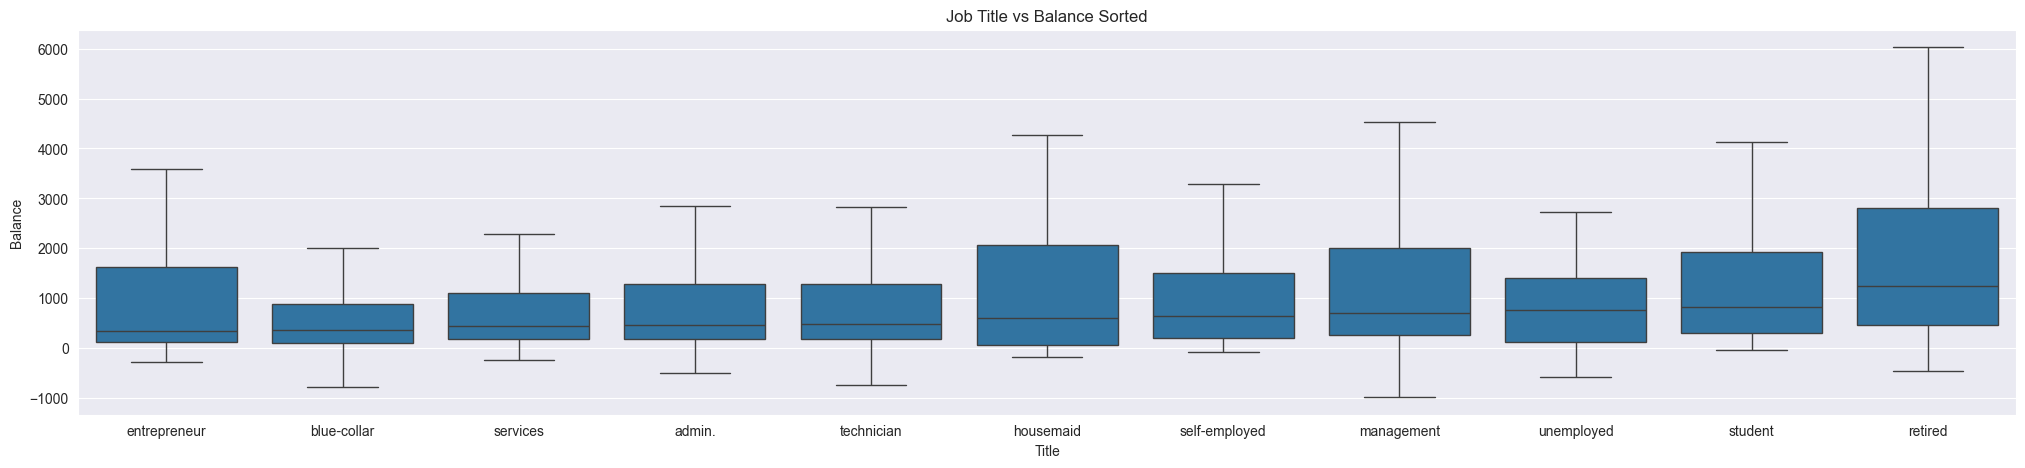

In [344]:
# for this plot i wanted to see how the balance per job title spread , i wanted to see who are the power users and who are the "fake" power customers
plt.figure(figsize=(25, 5))

medians = df.groupby('job')['balance'].median().sort_values(ascending=True)

sns.boxplot(x='job', y='balance', data=df, orient='v', showfliers=False, order=medians.index)

plt.title('Job Title vs Balance Sorted')
plt.xlabel('Title')
plt.ylabel('Balance')
plt.show()

C:\Users\jorgeblx\AppData\Local\Temp\ipykernel_32332\3355037543.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45)


Text(0.5, 1.0, 'Contact vs Subscribed')

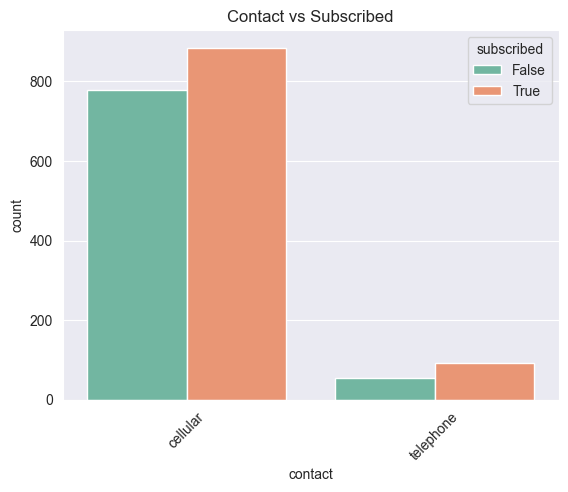

In [345]:
# simple plot type of contact vs result , as expected mobil is the choose method

plot = sns.countplot(x='contact', hue='subscribed', data=df, palette="Set2")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plt.title('Contact vs Subscribed')

C:\Users\jorgeblx\AppData\Local\Temp\ipykernel_32332\1213811218.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x="pdays", data=df, bins=15, kde=False, ax=axes[1, 0], palette="Set2")


<Axes: xlabel='pdays', ylabel='poutcome'>

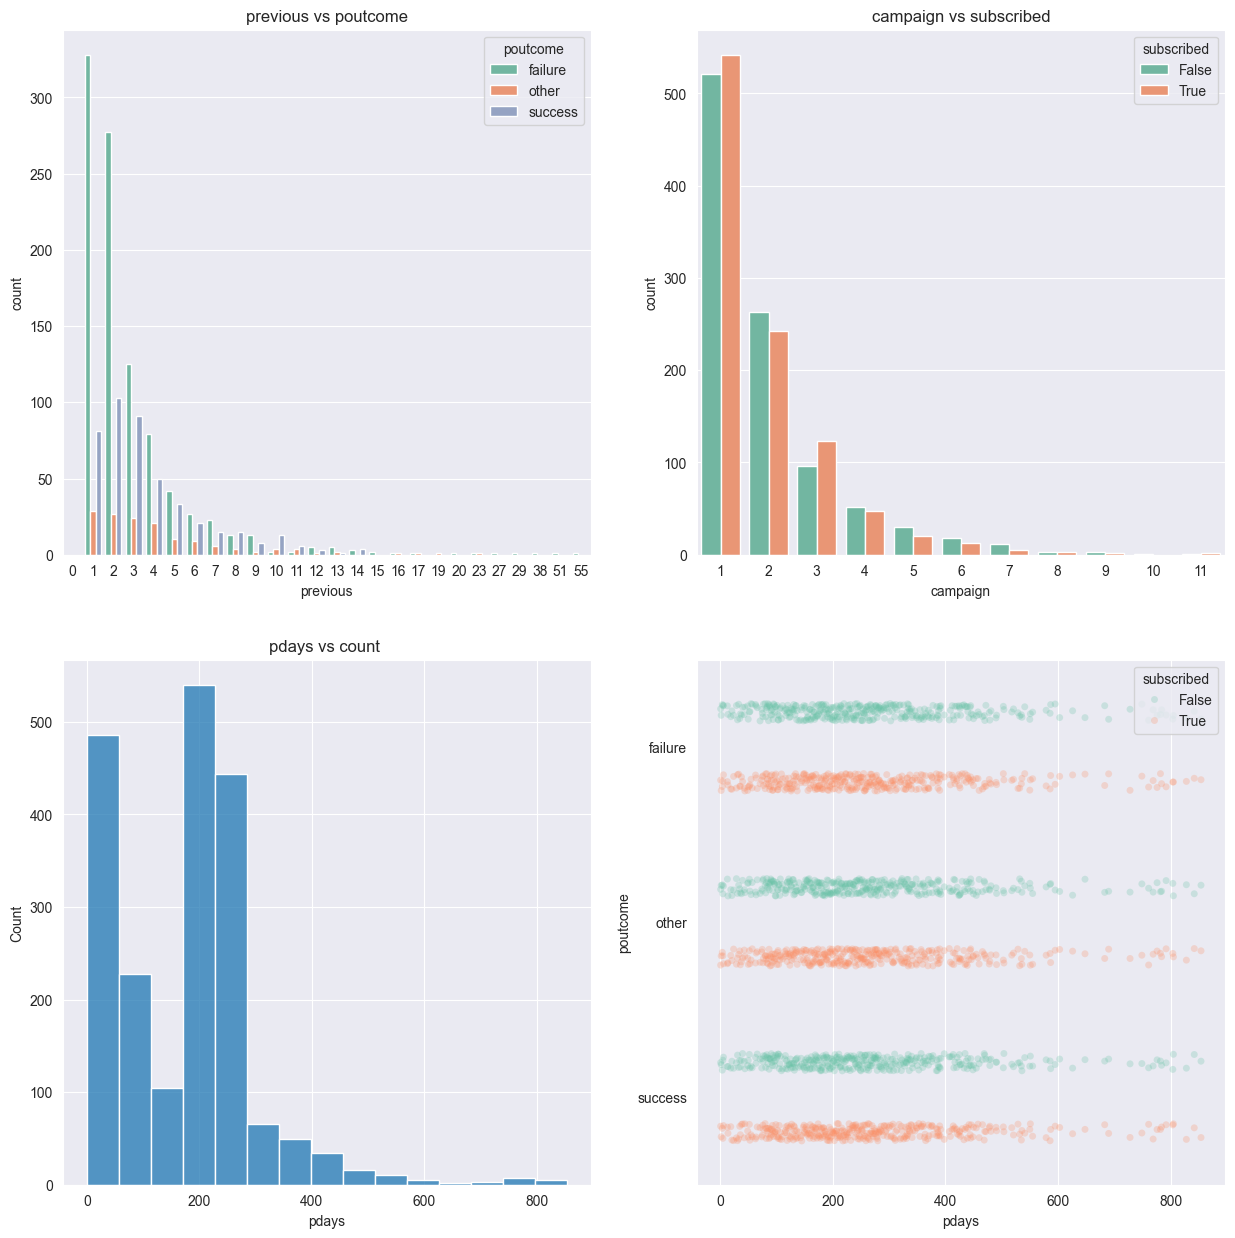

In [346]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# with this plot, I wanted to see the number of time a customer was contacted in the past and the outcome
# nice trend after the 3 rd call
plot = sns.countplot(x='previous', hue='poutcome', data=df, ax=axes[0, 0], palette="Set2")
axes[0, 0].set_title('previous vs poutcome')

# in this plot I wanted to see the number of times a customer was called in the current campaign
# nice trend from the 1st call the numbers look good - it implies it was much better targeted
plot = sns.countplot(x='campaign', hue='subscribed', data=df, ax=axes[0, 1], palette="Set2")
axes[0, 1].set_title('campaign vs subscribed')

# i wanted to see how the data was distributed , that 800 day max value looks waist-full
sns.histplot(x="pdays", data=df, bins=15, kde=False, ax=axes[1, 0], palette="Set2")
axes[1, 0].set_title('pdays vs count ')

filtered_df = df
crosstab = pd.crosstab([filtered_df['poutcome'], filtered_df['subscribed']], filtered_df['pdays'])
crosstab = crosstab.reset_index()
melted_crosstab = crosstab.melt(id_vars=['poutcome', 'subscribed'])

# this is my fancy graph - I wanted to see if my leaving people alone , how that impacted the outcome of the current campaign
# there is no clear trend , True and False are very similar
sns.stripplot(
    data=melted_crosstab, x="pdays", y="poutcome", hue="subscribed",
    dodge=True, alpha=.25, zorder=1, legend=True, palette="Set2"
)

C:\Users\jorgeblx\AppData\Local\Temp\ipykernel_32332\604856910.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_month['month'] = pd.Categorical(day_month['month'], categories=months_order, ordered=True)


<Axes: xlabel='month', ylabel='day'>

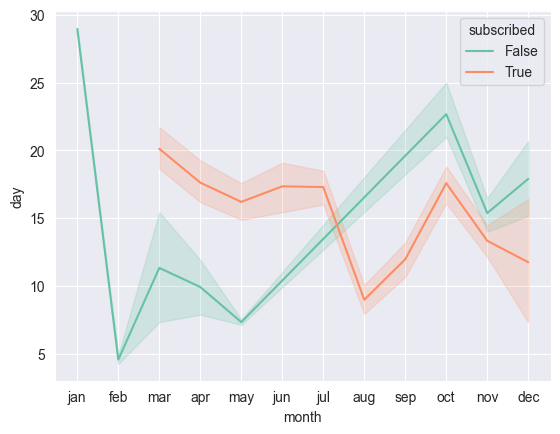

In [347]:
# for some reason I wanted to see the relation between the day / month and subscribed
# an idea was floated if we could distinguish between a light / heavy / birthday  month and the day in the month
# from the plot before it looks there is a clear separation

# I wanted to see how the week-day affected the outcome , but since we don't have the year parameter
# that is almost impossible to calculate accurately from day / month . But the chart below looks very good

months_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

day_month = df[['day','month', 'subscribed']]

day_month['month'] = pd.Categorical(day_month['month'], categories=months_order, ordered=True)

sns.lineplot(data=day_month, y='day', x='month', hue='subscribed', palette="Set2")

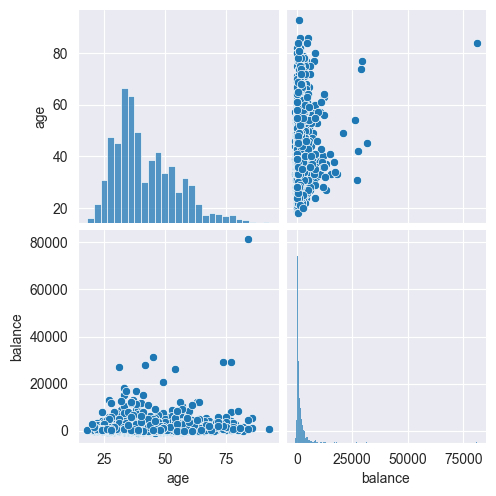

In [348]:
# show me the link between age and balance

sns.pairplot(data=df[['age','balance']].dropna())
plt.show()

In [349]:
df.groupby("marital").count()

,age,job,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,subscribed
marital,,,,,,,,,,,,,,,
divorced,215,215,205,215,215,215,215,198,215,215,215,215,215,170,215
married,1103,1105,1055,1111,1111,1111,1111,1000,1111,1111,1111,1111,1111,894,1111
single,670,670,636,674,674,674,674,611,674,674,674,674,674,482,674


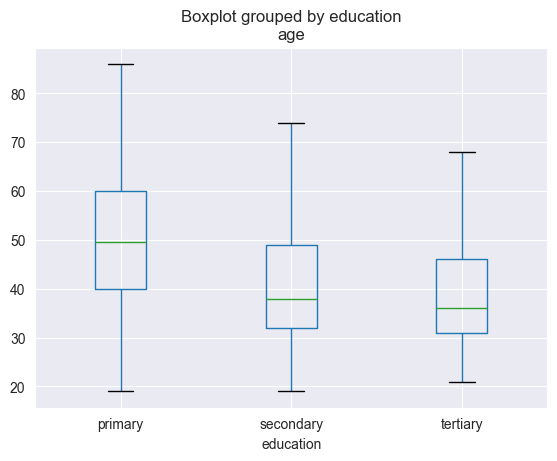

<Axes: xlabel='education'>

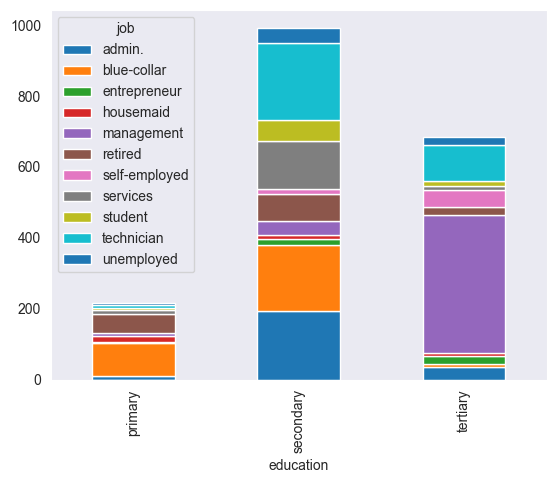

In [350]:
# this one is for political correctness

df.boxplot(column='age', by='education', showfliers=False)
plt.show()

# i wanted top see how the jobs titles are spread across education
crosstab = pd.crosstab(df['education'], df['job'])
crosstab.plot(kind='bar', stacked=True, grid=False)

In [351]:
df_transformed = df

In [352]:
# predict the missing value for the numeric column

imputer = KNNImputer(n_neighbors=3)
df_transformed['age'] = imputer.fit_transform(df[['age']])

In [353]:
# columns created  ---------------------------------------------------------------------

# 1

# sum the existence of housing or loan
df_transformed['product_count'] = df_transformed[['housing', 'loan']].sum(axis=1)

# 2

# created a new column - want to see the break-down of ages to confirm the most active age demographic
bins = [0, 20, 30, 40, 50, 60, 70, 200]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71+']

df_transformed['age_bucket'] = pd.cut(df_transformed['age'], bins=bins, labels=labels, right=False)

# 3 -- useless feature
# I wanted to see if the call count could be used to relate to the outcome
# from the grpah below it added no benefit
df_transformed['contact_count_state'] = df_transformed.apply(
    lambda row: 'down' if row['previous'] > row['campaign'] else 'same' if row['previous'] == row['campaign'] else 'up',
    axis=1)


subscribed
False    0.967
True     0.246
Name: product_count, dtype: float64


C:\Users\jorgeblx\AppData\Local\Temp\ipykernel_32332\52539877.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_transformed.groupby('age_bucket')['subscribed'].mean().plot.bar(ax=axes[1, 1])


Text(0.5, 1.0, 'Age Buckets vs Subscribed')

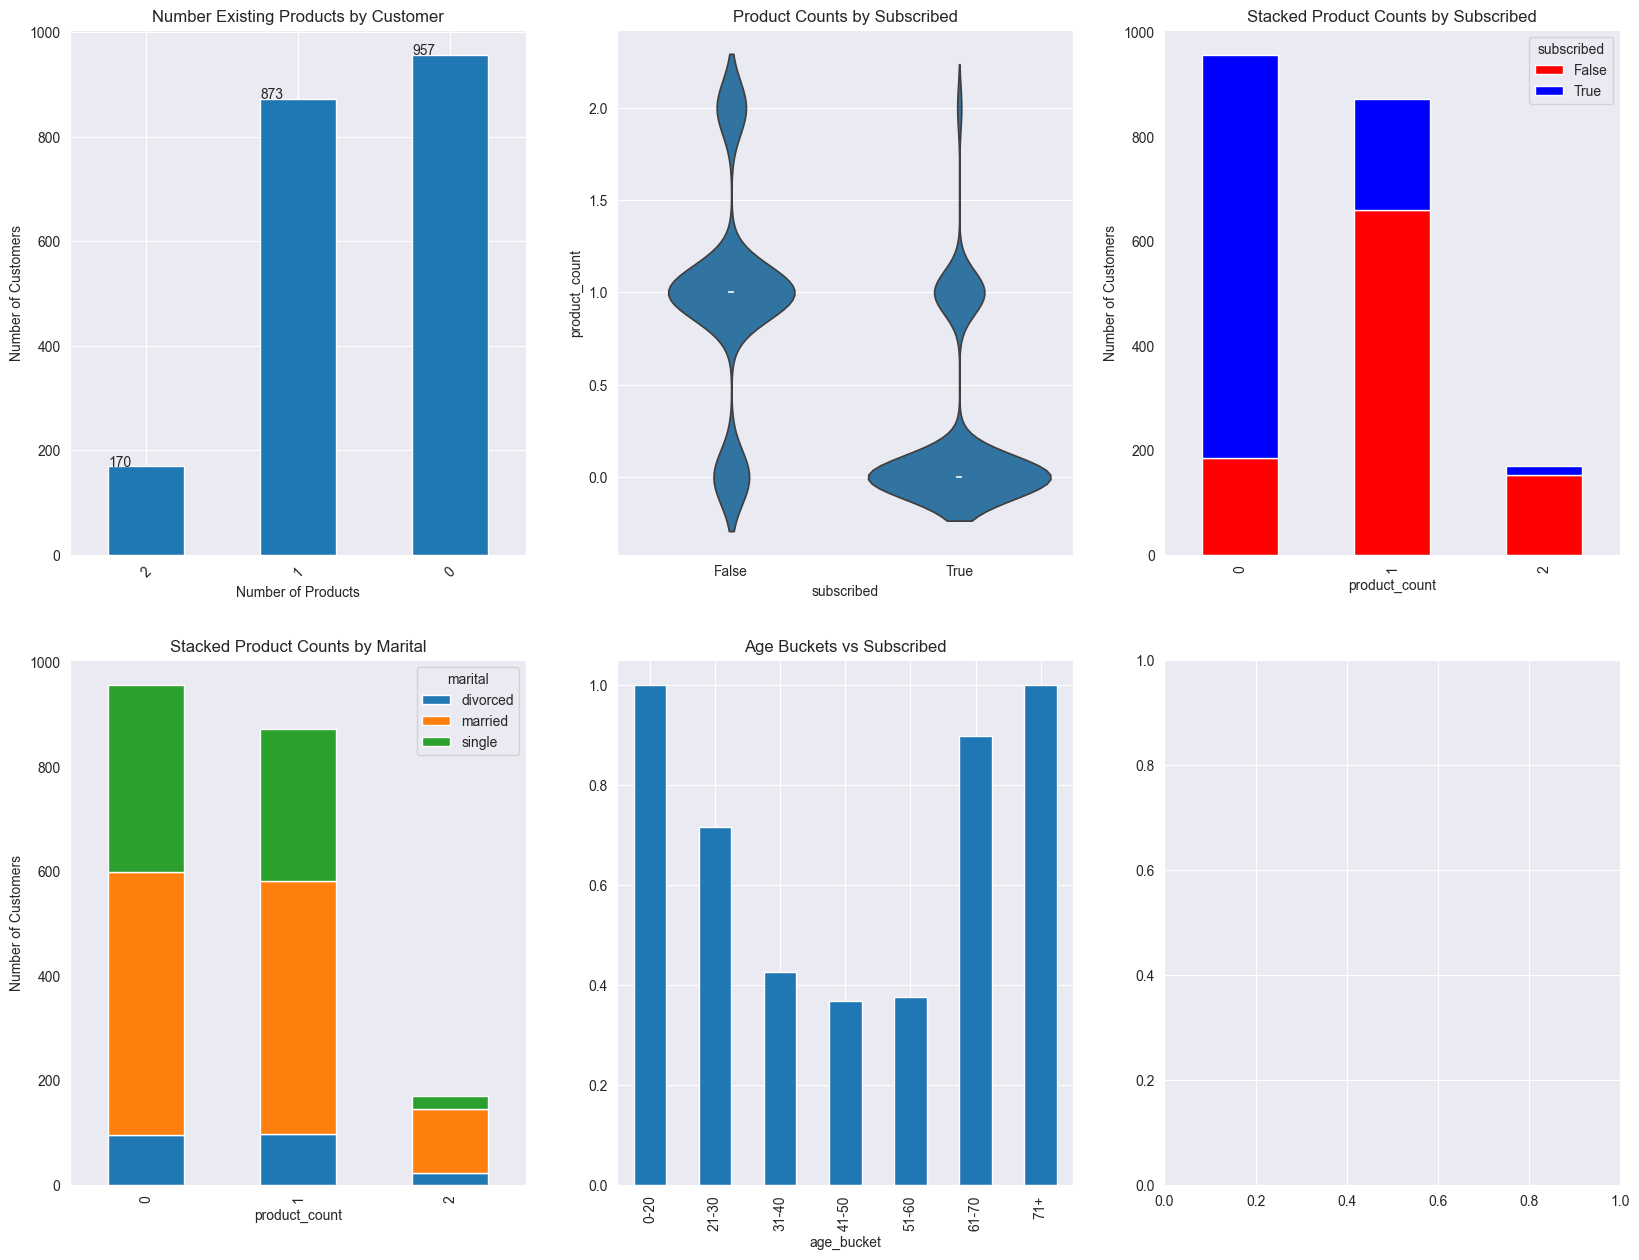

In [354]:
frequency_table = df_transformed['product_count'].value_counts(ascending=True)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))

# Note: in my mind 'loan' and 'home' could be combined in to 1 column ,
# as I thought it is better to combine them in to a single count and drive the stats from that count , than using the two column independently

# first plot :) - so i wanted to print the number at the top of the bar
# to indicate the number of users have 1 / 2or 0 products
ax = frequency_table.plot(kind='bar', ax=axes[0, 0])

axes[0, 0].set_xlabel('Number of Products')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].set_title('Number Existing Products by Customer')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# add the value at the top of the bar - easy to read
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()))

# the stat implies the more products you have the less likely you are to get another product
# but not impossible
print(df.groupby('subscribed')['product_count'].mean())

# this is another key plot for me and same result as the one below
# to indicate people with 2 > products are less likly to say yes to a new product
sns.violinplot(data=df_transformed, x='subscribed', y='product_count', ax=axes[0, 1])
axes[0, 1].set_title('Product Counts by Subscribed')

# another cool - i wanted to see how many customers with preexisting products said yes / no in the current campaighn
crosstab = pd.crosstab(df_transformed['product_count'], df_transformed['subscribed'])
crosstab.plot(kind='bar', stacked=True, color=['red', 'blue'], grid=False, ax=axes[0, 2])
axes[0, 2].set_ylabel('Number of Customers')
axes[0, 2].set_title('Stacked Product Counts by Subscribed')

# the cool once - I wanted to see a break-down of all the marital status, how it is
# spread across the count of products, how many groups have 1 / 2 or zero products
# as expected the marries are the power users , followed by the single and the divorced
# I have a chart below with indicates that divorced have only primary education, that would explain low income
crosstab = pd.crosstab(df_transformed['product_count'], df_transformed['marital'])
crosstab.plot(kind='bar', stacked=True,  grid=False, ax=axes[1, 0])
axes[1, 0].set_ylabel('Number of Customers')
axes[1, 0].set_title('Stacked Product Counts by Marital')

# this is the age bucket plot, I wanted to see the customers most active
# who are th emost active students / retired , the middle buckets are not so active
df_transformed.groupby('age_bucket')['subscribed'].mean().plot.bar(ax=axes[1, 1])
axes[1, 1].set_title('Age Buckets vs Subscribed')

C:\Users\jorgeblx\AppData\Local\Temp\ipykernel_32332\3950341056.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45)


[Text(0, 0, 'same'), Text(1, 0, 'up'), Text(2, 0, 'down')]

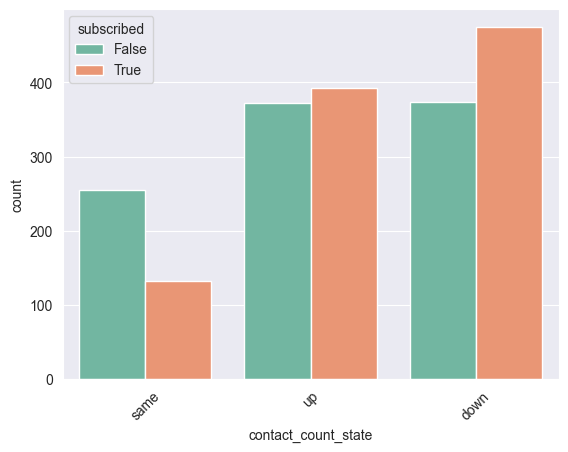

In [355]:
# I wanted to see if the number of times a customer was contacted in the previous campaign had any relation with the number of times in the current campaign
# the new column adds no value , as there is no pattern

plot = sns.countplot(x='contact_count_state', hue='subscribed', data=df_transformed, palette="Set2")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

<Axes: xlabel='age_bucket'>

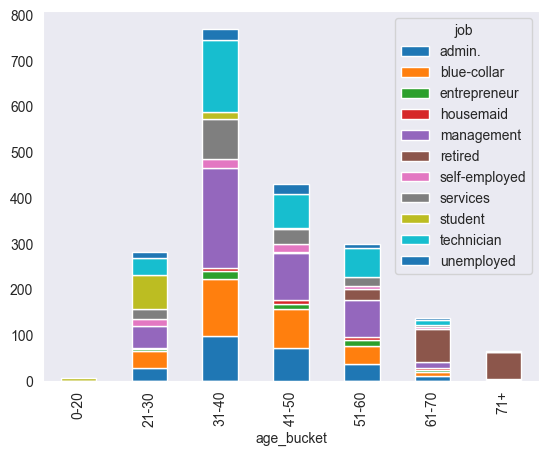

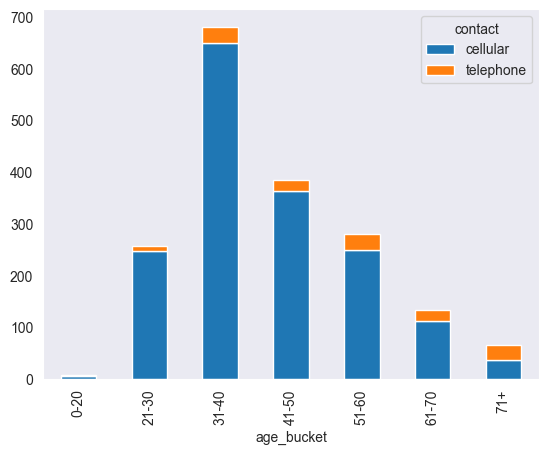

In [356]:

# i wanted to see how the job titles are spread across age buckets
crosstab = pd.crosstab(df_transformed['age_bucket'], df_transformed['job'])
crosstab.plot(kind='bar', stacked=True, grid=False)

# i wanted to see the predominant method of communication per age bucket
crosstab = pd.crosstab(df_transformed['age_bucket'], df_transformed['contact'])
crosstab.plot(kind='bar', stacked=True, grid=False)

In [357]:
# show me only the columns with missing values and the percentage
# if the % of the missing values is height we may drop the column
# missing values not numeric all enum types

missing_values_count = df_transformed.isnull().sum()
missing_percentage = (missing_values_count / len(df)) * 100

missing_data_summary = pd.DataFrame({
    'Missing Count': missing_values_count,
    'Missing % Total': missing_percentage
})

missing_data_summary = missing_data_summary[missing_data_summary['Missing Count'] > 0]

print(missing_data_summary)

           Missing Count  Missing % Total
job                   10             0.50
education            104             5.20
contact              191             9.55
poutcome             454            22.70


In [ ]:
df_transformed

In [358]:
# predict the missing values as the numbers are too large and they may impact the data

df_transformed.loc[df['job'].isnull(), 'job'] = predict_missing_values(df_transformed, 'job')

df_transformed.loc[df['education'].isnull(), 'education'] = predict_missing_values(df_transformed, 'education')

df_transformed.loc[df['contact'].isnull(), 'contact'] = predict_missing_values(df_transformed, 'contact')

df_transformed.loc[df['poutcome'].isnull(), 'poutcome'] = predict_missing_values(df_transformed, 'poutcome')

In [359]:
df_transformed

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,subscribed,product_count,age_bucket,contact_count_state
0,32.0,technician,single,tertiary,False,392,True,False,cellular,1,apr,2,131,2,failure,False,1,31-40,same
1,39.0,technician,divorced,secondary,False,688,True,True,cellular,1,apr,2,133,1,failure,False,2,31-40,up
2,59.0,retired,married,secondary,False,1035,True,True,cellular,1,apr,2,239,1,failure,False,2,51-60,up
3,47.0,blue-collar,married,secondary,False,398,True,True,cellular,1,apr,1,238,2,failure,False,2,41-50,down
4,54.0,retired,married,secondary,False,1004,True,False,cellular,1,apr,1,307,1,failure,False,1,51-60,same
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,20.0,student,single,primary,False,2785,False,False,cellular,16,sep,2,-1,0,failure,True,0,21-30,up
1996,28.0,admin.,single,secondary,False,127,False,False,cellular,16,sep,2,-1,0,failure,True,0,21-30,up
1997,81.0,retired,married,primary,False,1154,False,False,telephone,17,sep,1,-1,0,failure,True,0,71+,up
1998,46.0,services,married,primary,False,4343,True,False,cellular,20,sep,1,-1,0,failure,True,1,41-50,up


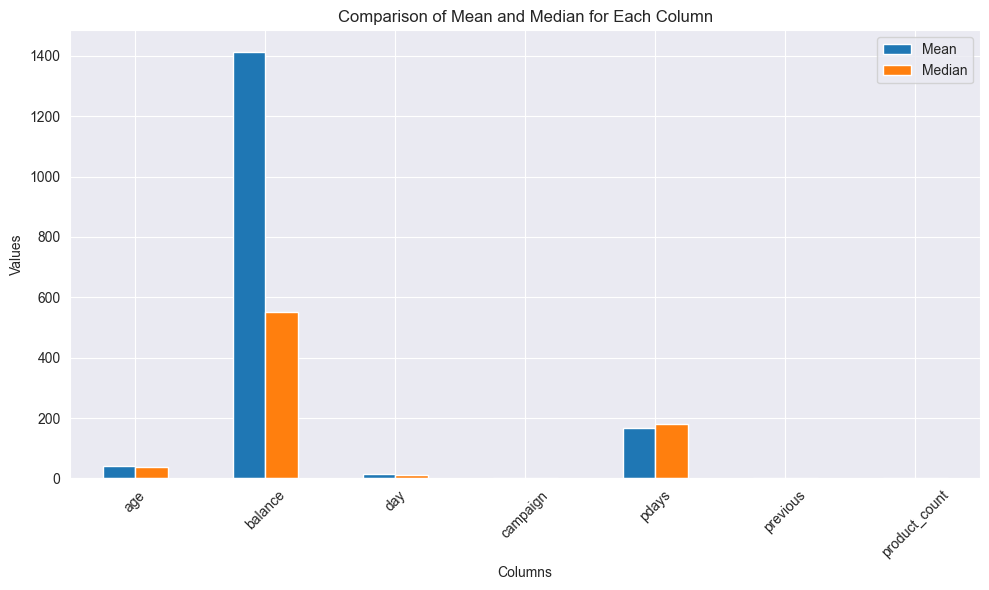

In [360]:
#skew in the data ---
# took all the numeric columns and compared mean / median

numeric_stats = df_transformed.describe()

mean_values = numeric_stats.loc["mean"]
median_values = numeric_stats.loc["50%"]

skew_comparison = pd.DataFrame({'Mean': mean_values, 'Median': median_values})

skew_comparison.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Mean and Median for Each Column')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

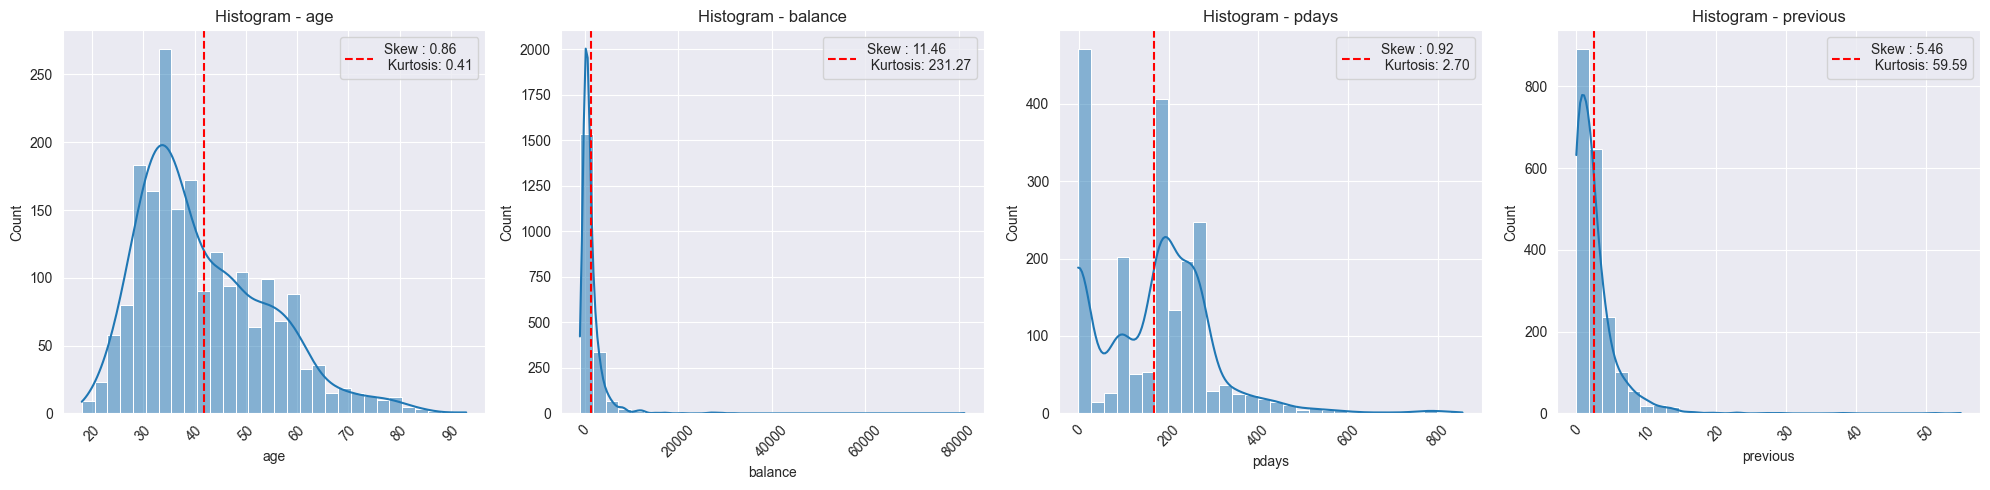

In [361]:
# display skew results on numeric columns, very fancy way of showing how data is shifter to the left or right from the center line
# and a fancy title for how long the tail is
# skew under .5 it is accepted to be ok
# age and balance no surprise

# kurtoise posssive up
# kurtoise negative flat
# kurtoise 0 normal :)

numeric_columns = ['age', 'balance', 'pdays', 'previous']

n = len(numeric_columns)
num_rows = (n // 4) + (n % 4 > 0)

plt.figure(figsize=(20, 5 * num_rows))

for index, column_name in enumerate(numeric_columns, start=1):

    target_column = df_transformed[column_name]

    plt.subplot(num_rows, 4, index)
    sns.histplot(x=column_name, data=df_transformed, bins=30, kde=True)

    skew_value, kurt_value = get_skeness_kurtosis(target_column)
    plt.axvline(target_column.mean(), color='r', linestyle='--', label=f'Skew : {skew_value:.2f}\n Kurtosis: {kurt_value:.2f}')
    plt.legend()

    plt.title(f"Histogram - {column_name}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

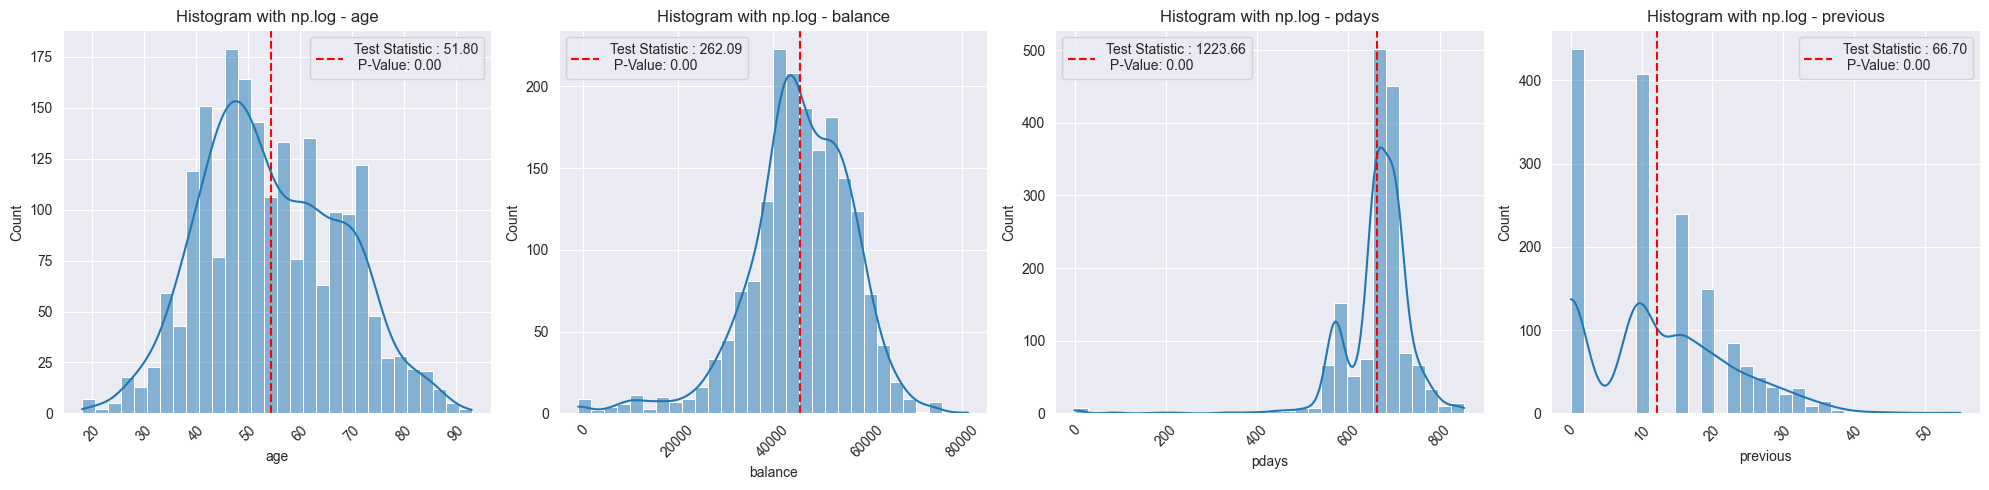

In [362]:
# display skew results with log transform on numeric columns
# as you can see age and balance has now shifted to the center

from scipy.stats import normaltest, probplot

numeric_columns = ['age', 'balance', 'pdays', 'previous']

n = len(numeric_columns)
num_rows = (n // 4) + (n % 4 > 0)

plt.figure(figsize=(20, 5 * num_rows))

for index, column_name in enumerate(numeric_columns, start=1):

    target_column = df_transformed[column_name]
    log_transformed = np.log(target_column[target_column > 0])

    normality_test_stat, normality_test_p_value = normaltest(log_transformed)

    plt.subplot(num_rows, 4, index)

    # after the log action the dat aon the plot doesnt make any sense so in a way we have to
    # transform the data back to somthing we understand
    normalized_column = normalize_log_transform_column(log_transformed, target_column)
    sns.histplot(normalized_column, bins=30, kde=True)

    plt.axvline(normalized_column.mean(), color='r', linestyle='--', label=f'Test Statistic : {normality_test_stat:.2f}\n P-Value: {normality_test_p_value:.2f}')
    plt.legend()

    plt.title(f"Histogram with np.log - {column_name}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

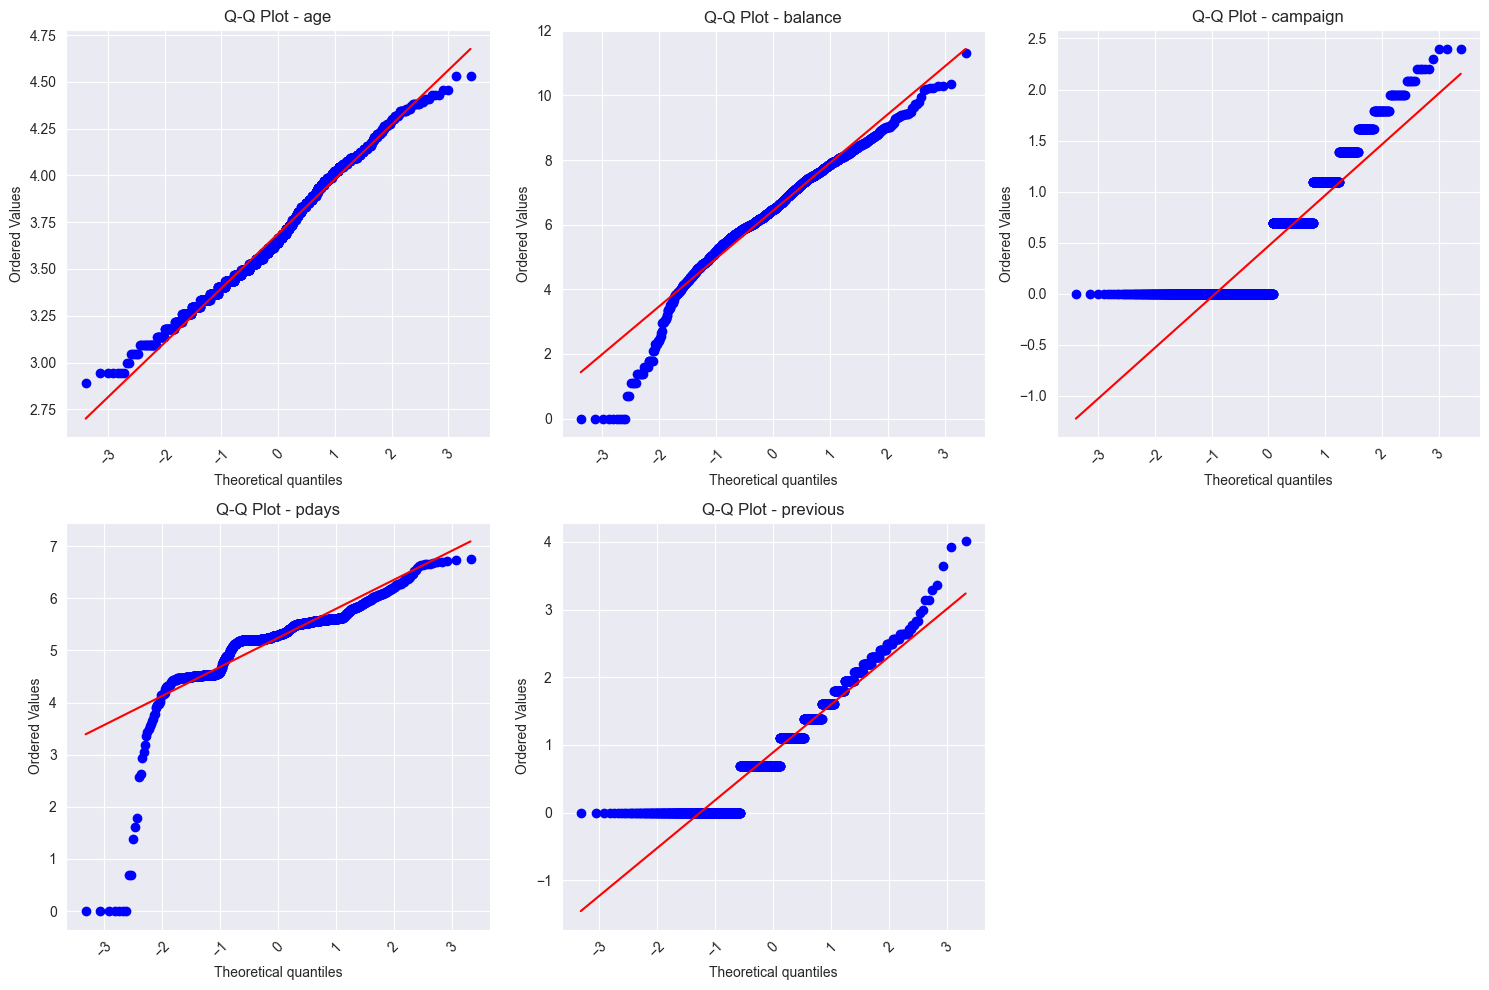

In [363]:
# once the log_transform is executed on the data , we have to validate to make sure
# it is good
from scipy.stats import normaltest, probplot

numeric_columns = ['age', 'balance', 'campaign', 'pdays', 'previous']

n = len(numeric_columns)
num_rows = (n // 3) + (n % 3 > 0)

plt.figure(figsize=(15, 5 * num_rows))

for index, column_name in enumerate(numeric_columns, start=1):

    target_column = df_transformed[column_name]
    log_transformed = np.log(target_column[target_column > 0])

    plt.subplot(num_rows, 3, index)

    probplot(log_transformed, dist="norm", plot=plt)

    plt.title(f"Q-Q Plot - {column_name}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [364]:
# use the label encoder to convert category columns to numeric columns

# nominal features - no order
label_encoder = LabelEncoder()
object_columns = ['job', 'marital', 'contact', 'poutcome', 'default', 'housing', 'loan', 'subscribed', 'contact_count_state']

for index, column_name in enumerate(object_columns, start=1):
    df_transformed[column_name] = label_encoder.fit_transform(df_transformed[column_name])

# ordinal feature - clear order

encoder = OrdinalEncoder(categories=[['primary', 'secondary', 'tertiary']], handle_unknown='use_encoded_value', unknown_value=-1)
df_transformed['education'] = encoder.fit_transform(df_transformed[['education']])

encoder = OrdinalEncoder(categories=[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']], handle_unknown='use_encoded_value', unknown_value=-1)
df_transformed['month'] = encoder.fit_transform(df_transformed[['month']])

encoder = OrdinalEncoder(categories=[['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71+']], handle_unknown='use_encoded_value', unknown_value=-1)
df_transformed['age_bucket'] = encoder.fit_transform(df_transformed[['age_bucket']])

In [365]:
df_transformed

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,subscribed,product_count,age_bucket,contact_count_state
0,32.0,9,2,2.0,0,392,1,0,0,1,3.0,2,131,2,0,0,1,2.0,1
1,39.0,9,0,1.0,0,688,1,1,0,1,3.0,2,133,1,0,0,2,2.0,2
2,59.0,5,1,1.0,0,1035,1,1,0,1,3.0,2,239,1,0,0,2,4.0,2
3,47.0,1,1,1.0,0,398,1,1,0,1,3.0,1,238,2,0,0,2,3.0,0
4,54.0,5,1,1.0,0,1004,1,0,0,1,3.0,1,307,1,0,0,1,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,20.0,8,2,0.0,0,2785,0,0,0,16,8.0,2,-1,0,0,1,0,1.0,2
1996,28.0,0,2,1.0,0,127,0,0,0,16,8.0,2,-1,0,0,1,0,1.0,2
1997,81.0,5,1,0.0,0,1154,0,0,1,17,8.0,1,-1,0,0,1,0,6.0,2
1998,46.0,7,1,0.0,0,4343,1,0,0,20,8.0,1,-1,0,0,1,1,3.0,2


In [366]:

# properties that got flagged to have outliers
robust_scaler = RobustScaler()
df_transformed[['balance', 'age', 'day', 'pdays']] = robust_scaler.fit_transform(df_transformed[['balance', 'age', 'day', 'pdays']])

# object based properties
min_max_scaler = MinMaxScaler()
df_transformed[['job', 'marital', 'education', 'contact' , 'campaign', 'previous' , 'poutcome', 'product_count' , 'age_bucket', 'contact_count_state']] = min_max_scaler.fit_transform(df_transformed[['job', 'marital', 'education', 'contact' , 'campaign', 'previous' , 'poutcome', 'product_count' , 'age_bucket', 'contact_count_state']])

# I left boolean properties as they are since we have a zero or 1 value

In [367]:
df_transformed

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,subscribed,product_count,age_bucket,contact_count_state
0,-0.333333,0.9,1.0,1.0,0,-0.110187,1,0,0.0,-0.611111,3.0,0.1,-0.291013,0.036364,0.0,0,0.5,0.333333,0.5
1,0.055556,0.9,0.0,0.5,0,0.094941,1,1,0.0,-0.611111,3.0,0.1,-0.279601,0.018182,0.0,0,1.0,0.333333,1.0
2,1.166667,0.5,0.5,0.5,0,0.335412,1,1,0.0,-0.611111,3.0,0.1,0.325250,0.018182,0.0,0,1.0,0.666667,1.0
3,0.500000,0.1,0.5,0.5,0,-0.106029,1,1,0.0,-0.611111,3.0,0.0,0.319544,0.036364,0.0,0,1.0,0.500000,0.0
4,0.888889,0.5,0.5,0.5,0,0.313929,1,0,0.0,-0.611111,3.0,0.0,0.713267,0.018182,0.0,0,0.5,0.666667,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1.000000,0.8,1.0,0.0,0,1.548164,0,0,0.0,0.222222,8.0,0.1,-1.044223,0.000000,0.0,1,0.0,0.166667,1.0
1996,-0.555556,0.0,1.0,0.5,0,-0.293832,0,0,0.0,0.222222,8.0,0.1,-1.044223,0.000000,0.0,1,0.0,0.166667,1.0
1997,2.388889,0.5,0.5,0.0,0,0.417879,0,0,1.0,0.277778,8.0,0.0,-1.044223,0.000000,0.0,1,0.0,1.000000,1.0
1998,0.444444,0.7,0.5,0.0,0,2.627859,1,0,0.0,0.444444,8.0,0.0,-1.044223,0.000000,0.0,1,0.5,0.500000,1.0


#